# Non linear analysis - Assignment 2 - Part c

11.10.2023 - Laure Toullier and Jérémie Engler

Initial stiffness and displacement controlled Newton-Raphson procedure

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Definitions

In [2]:
# Element connectivity
nelements = 2 
nnodes = 3

# Written input:
connectivity = np.array([[1, 2], [2, 3]])
nodes_P = np.array([2])

# Unit stiffness matrix of bar in local coordinate system
K_unit = np.array([[1, 0, -1, 0], 
                   [0, 0,  0, 0], 
                   [-1, 0, 1, 0], 
                   [0, 0, 0, 0]])
NDOF = 2*len(nodes_P)

# Input data and element stiffness matrices
E = [200e3,200e3]  # N/mm^2 Young modulus of the elements
A = [15e3,2e3] #mm^2 Cross-sectional area of the elements
a = 3000 #mm Half lenght of the truss
b = 4000 #mm Height of the truss
P = 10000e3 #7862e3 #N Load
phiP = 60 #° Angle of load
theta = [53.13, -53.13] #° Angle of elements, at first node of the element
Pglob = np.array([P*np.cos(np.radians(phiP)), P*np.sin(np.radians(phiP))]) #N P force in global coordinates (x,y)
alpha = 0.02
sigmay = 500 #Mpa
epsy = sigmay/E[0] # Only if all the bars have the same sigmay and E
disp_incr = 0.1 #mm

disp_max = 60 #mm
iter_lim = 20

#Variables and tracking vectors initialization

plastifiedelem = [] #Track which elements are plastified
Pcp = []
lambdatemp = []
alphaelem = [1,1]
Ucp = np.zeros((nelements,2,1))
Pglobit = Pglob
numnodesP = len(nodes_P)

print(Pglob)

[5000000.         8660254.03784439]


Functions definitions

In [3]:
def constitutive_law_force(T,L,i,u):
    P = E[i] * A[i] * u[i]
    return P

def constitutive_law_stiffness(T,L,i,u):
    ki = E[i] * A[i] / L[i]
    return ki

def lengths_rotmat_and_Fy():

    #Length of elements, rotation matrices and yielding forces

    T = np.zeros((nelements,4,4))
    L = []
    Fy = []

    for i in range(nelements):
        c = np.cos(np.radians(theta[i]))
        s = np.sin(np.radians(theta[i]))
        Li = abs(a/c)
        if theta[i] == -90:
            Li = b
        T[i] = np.array([[c, s, 0, 0], 
                [-s, c, 0, 0], 
                [0, 0, c, s], 
                [0, 0, -s, c]])
        L.append(Li)
        Fyi = sigmay * A[i]
        Fy.append(Fyi)

    return L,T,Fy

def u_y(sigmay, L, E):
    uy = []
    for i in range(nelements):
        uy.append(sigmay * L[i] / E[i])
    return uy
    
def stiffness_matrices(T,L):

    k = []
    k_glob = np.zeros((nelements,4,4))

    #Stiffness matrices

    for i in range(nelements):
        ki = constitutive_law_stiffness(T,L,i,0)
        k.append(ki)
        k_glob[i] = ki * T[i].T @ K_unit @ T[i]
    
    return k,k_glob

def assemble(alphaelem, k_glob):
    # Assemble global stiffness matrix
    NDoF = 2*nnodes
    K_global = np.zeros((NDoF,NDoF))
    K_globals = np.zeros((nelements,NDoF, NDoF))
# Assemble elements
    for i in range (nelements):
        connectelem = connectivity[i] #nodes connected to the element
        indexs = 2*connectelem
        i11 = indexs[0]-2
        i12 = indexs[0]
        i21 = indexs[1]-2
        i22 = indexs[1]

        Ki_global = np.zeros((NDoF, NDoF))
        ki_global = alphaelem[i]*k_glob[i]
        Ki_global[i11:i12, i11:i12] = ki_global[0:2, 0:2]
        Ki_global[i21:i22, i11:i12] = ki_global[2:4, 0:2]
        Ki_global[i11:i12, i21:i22] = ki_global[0:2, 2:4]
        Ki_global[i21:i22, i21:i22] = ki_global[2:4, 2:4]
        # print(f"Ki_global = {Ki_global}")
        K_global = K_global + Ki_global
        K_globals[i] = Ki_global

    return(K_global,K_globals)

def u_vec_and_F(P,K_global):
    # Calculate displacements at nodes with forces applied
    numnodesP = len(nodes_P)
    F_red = P
    # print(f"Applied force at iteration {len(plastifiedelem)} = {F_red}")
    indexssup = 2*nodes_P - 1
    indexsinf = indexssup - 1
    mask = []
    for i in range(numnodesP):
        mask.append(indexsinf[i])
        mask.append(indexssup[i])
    K_red = K_global[mask,:]
    K_red = K_red[:,mask]

    #print(f"K_red = {K_red}")

    u_red = np.linalg.inv(K_red) @ F_red

    # print(u_red)
    # print(f"Displacement at iteration {len(plastifiedelem)} = {u_red}")

    # Calculate reaction forces at other nodes
    u_vec = np.zeros((2*nnodes))

    for i in range(numnodesP):
        u_vec[indexsinf[i]] = u_red[2*i]
        u_vec[indexssup[i]] = u_red[2*i+1]

    F = K_global @ u_vec

    return(u_vec,F)

def axialforces(K_globals,u_vec,T):
    axialF = []
    F_ele_reds = np.zeros((nelements, 4))
    pr=np.zeros((nelements,2*nnodes))

    for i in range(nelements):
        F_elei = K_globals[i] @ u_vec
        index_red = 2*connectivity[i]
        F_elei_red = F_elei[[index_red[0]-2, index_red[0]-1, index_red[1]-2, index_red[1]-1]]
        F_elei_local = T[i] @ F_elei_red
        Fi = F_elei_local[2]
        #print(f"Fi = {Fi}")
        F_ele_reds[i,:] = F_elei_red
        axialF.append(Fi)

        pr[i,int((index_red[0]-2))]=F_ele_reds[i,0]
        pr[i,int((index_red[0]-1))]=F_ele_reds[i,1]
        pr[i,int((index_red[1]-2))]=F_ele_reds[i,2]
        pr[i,int((index_red[1]-1))]=F_ele_reds[i,3]   

    Pr_output=pr.sum(axis=0)       

    return(axialF, F_ele_reds , Pr_output)

def axialforces_withload(P,T): #UNSTABLE - NOT WORKING
    axialF = []
    for i in range(nelements):
        F_elei_red = P
        F_elei_local = T[i] @ F_elei_red
        Fi = F_elei_local[2]
        print(f"Fi = {Fi}")
        axialF.append(Fi)

    return(axialF)

def printgraph(x,y,xname,yname,unit1, unit2):
    plt.plot(x,y,'o')
    plt.plot(x,y,'b')

    plt.title(f'{yname} as a function of {xname}')
    plt.xlabel(f"{xname} ({unit1})")
    plt.ylabel(f"{yname} ({unit2})")

    plt.show()

    return None

def printgraph2(x,y,xname,yname,unit1, unit2):
    plt.plot(x,y,'b')

    plt.title(f'{yname} as a function of {xname}')
    plt.xlabel(f"{xname} ({unit1})")
    plt.ylabel(f"{yname} ({unit2})")

    plt.show()

    return None

def points_archives(u,v,px,py,p):

    for i in nodes_P:
        j = i-1
        u.append(u_vec[2*j]+u[-1])
        v.append(u_vec[2*j+1]+v[-1])
        px.append(F[2*j]+px[-1])
        py.append(F[2*j+1]+py[-1])
        p.append(F[2*j]/np.cos(phiP)+p[-1])
    return u,v,px,py,p

def u_strain(Connectivity, u, L0, T, nb_members):
    
    #displacements in global coordinates
    u_red=np.zeros(nb_members*4).reshape((nb_members,4))
    for i in range(nb_members):
        if i == 0: 
            u_red[i, 0] = 0  
            u_red[i, 1] = 0
            u_red[i, 2]=u[0]
            u_red[i, 3]=u[1]
        if i == 1:
            u_red[i, 0]=u[0]      
            u_red[i, 1]=u[1]
            u_red[i, 2]=0
            u_red[i, 3]=0

        #print("u_red = ", u_red)
    
    #displacements in local coordinates
    u_bar=[]
    for i in range(nb_members):
        u_bar.append(T[i]@u_red[i,:])
    
    u_bar=np.array(u_bar)
    
    #calculate the strain in each bar
    strain=[]
    for i in range(nb_members):  
        strain.append((u_bar[i,2]-u_bar[i,0])/L0[i])
        
    strain=np.array(strain)
    
    return u_bar, strain

def internal_force(Connectivity, area, alpha, E0, u, L, T, sigma_0, eps_0, nb_members):
    

    #internal force in each bar

    u_red, u_red_loc, eps=strain (u, L, T, nb_members, Connectivity)
    pr_local=np.zeros((nb_members,4))
    pr_global=np.zeros((nb_members, 4))
    pr=np.zeros((nb_members,DOF))
    Pr=np.zeros(DOF)

    for i in range(nb_members):
        if np.abs(eps[i])>eps_0[i]:
            E[i]=alpha*E0[i]
            print(f"{E[i]=}  {E0[i]}  {alpha}")
            a= (sigma_0[i]*area[i] + E[i]* area[i] * (np.abs(eps[i])-eps_0[i]))*np.sign(eps[i])
        else:
            E[i]=E0[i]
            a=E[i]*area[i]*np.abs(eps[i])*np.sign(eps[i])
            print(f"{E[i]=}  {area[i] = }  {eps[i] = }")

        pr_local[i,0]=-a
        pr_local[i,2]=a

        pr_global[i,:]=T[i].T@pr_local[i,:]
        print(f"{pr_global = }")

        index_1=Connectivity[i,0] #value of 1st node of the bar
        index_2=Connectivity[i,1] #value of 2nd node of the bar
        pr[i,(index_1-1)*2]=pr_global[i,0]
        pr[i,(index_1)*2-1]=pr_global[i,1]
        pr[i,(index_2-1)*2]=pr_global[i,2]
        pr[i,index_2*2-1]=pr_global[i,3]   

    Pr=pr.sum(axis=0)
    print(f"{Pr = }")

    return Pr #Pr at node 2 in global coordinates (2*1)

Displacement controlled Newton-Raphson procedure

[0.02, 1]
[0.02, 0.02]


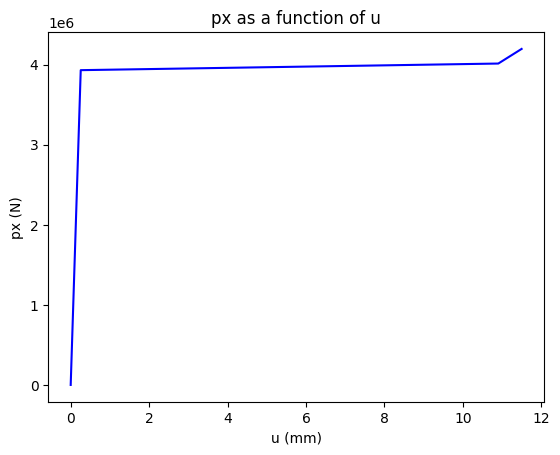

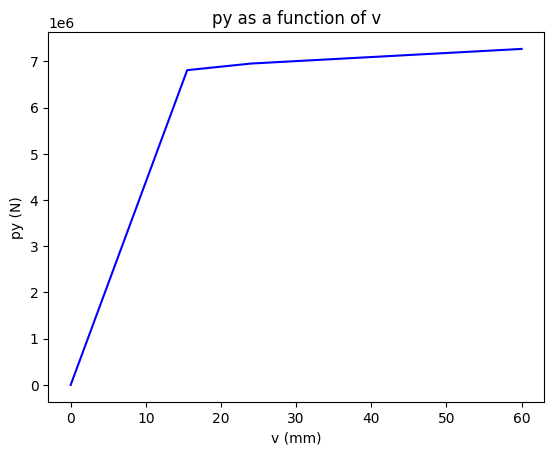

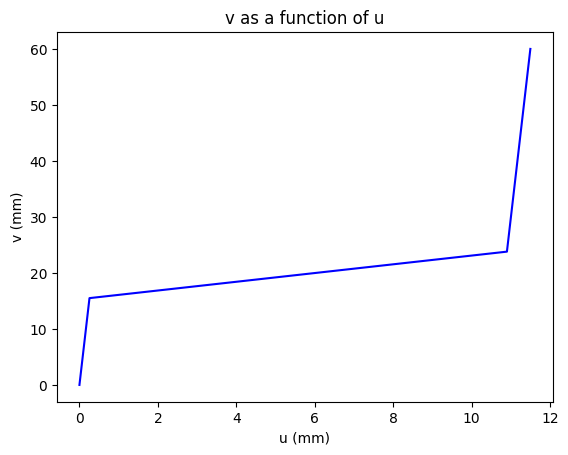

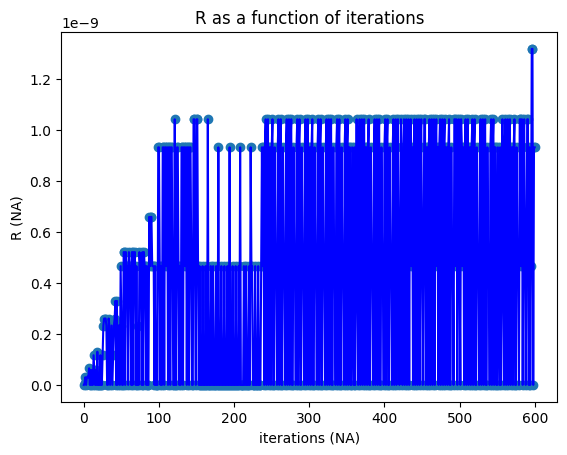

[0.02, 0.02]
[0, 7.275957614183426e-12, 2.9999541770795335e-11, 0.0, 2.9103830456733704e-11, 3.253907165344266e-11, 2.9103830456733704e-11, 6.507814330688532e-11, 0.0, 5.820766091346741e-11, 0.0, 5.820766091346741e-11, 0.0, 1.1641532182693481e-10, 5.820766091346741e-11, 0.0, 5.820766091346741e-11, 0.0, 1.3015628661377063e-10, 0.0, 0.0, 0.0, 1.1641532182693481e-10, 0.0, 0.0, 1.1641532182693481e-10, 2.3283064365386963e-10, 2.6031257322754127e-10, 2.6031257322754127e-10, 2.6031257322754127e-10, 2.3283064365386963e-10, 0.0, 0.0, 2.6031257322754127e-10, 2.3283064365386963e-10, 0.0, 1.1641532182693481e-10, 2.3283064365386963e-10, 0.0, 1.1641532182693481e-10, 2.3283064365386963e-10, 2.6031257322754127e-10, 3.2927225399135965e-10, 0.0, 3.2927225399135965e-10, 0.0, 2.3283064365386963e-10, 2.3283064365386963e-10, 0.0, 4.656612873077393e-10, 2.3283064365386963e-10, 0.0, 0.0, 5.206251464550825e-10, 5.206251464550825e-10, 0.0, 5.206251464550825e-10, 4.656612873077393e-10, 4.656612873077393e-10, 0.0

In [4]:
L,T,Fy = lengths_rotmat_and_Fy()
k,k_glob = stiffness_matrices(T,L)
tol = P / 1e6
lambda_ = 0
step = 0
all_lambdas_archives = []
all_lambdas_points = []
lambdas_archives = []
disp = np.zeros((2))
all_displacement_points = []
displacement_points = []
bm = np.zeros((2))
bm[1] = 1
Pr = np.zeros((numnodesP*2))
R_it = np.zeros((2))
iteration = 0

#Initialisation of the plotted vectors

u = [0]
v = [0]
px = [0]
py = [0]
p = [0]
r = [0]
iterations = [0]

while disp[1] < disp_max:
    step += 1
    disp_it = np.zeros((2))

    for j in range(iter_lim):
        #print("Start of iteration", j+1, "step", step)

        iteration += 1


        if j == 0:
            disp_it[1] = disp_incr
        else:
            disp_it[1] = 0

        # Assemble elements

        k,k_glob = stiffness_matrices(T, L)

        K_global, K_globals = assemble(alphaelem, k_glob) # Tangent stiffness

        #Reduction of the global matrix

        indexssup = 2*nodes_P - 1
        indexsinf = indexssup - 1
        mask = []
        for i in range(numnodesP):
            mask.append(indexsinf[i])
            mask.append(indexssup[i])
        K_red = K_global[mask,:]
        K_red = K_red[:,mask]

        # Delta load factor and delta displacement in other direction computations

        K_T_inv = np.linalg.inv(K_red)

        lambda_it = (-bm.T @ K_T_inv @ R_it + bm.T @ disp_it) / (bm.T @ K_T_inv @ Pglob)

        disp_it = K_T_inv @ (lambda_it * Pglob + R_it)

        # Total load factor and displacement for iteration 

        lambda_ = lambda_ + lambda_it

        all_lambdas_archives.append(lambda_)

        if step == 1 and j==0:
            all_lambdas_points.append(all_lambdas_archives[-1])
        else:
            all_lambdas_points.append(all_lambdas_points[-1] + all_lambdas_archives[-1])
        
        disp = disp + disp_it

        all_displacement_points.append(disp)

        #External applied load

        Pn = lambda_ * Pglob #Global coordinates, vecteur de 2 elements

        #Internal resistance force

        u_vec = np.zeros((nnodes*2))
        u_vec[2] = disp_it[0]
        u_vec[3] = disp_it[1]

        axialPr, Pr_elem, Pr_it= axialforces(K_globals,u_vec,T)

        Pr = Pr + Pr_it[2:4]

        #Residual forces

        R_it = Pn.reshape(2) - Pr #[2:4]

        r.append(np.linalg.norm(R_it))
        iterations.append(iteration)

        # print("Pglob =", Pglob)
        # print("KT = ", K_red)
        # print("K_T_inv = ", K_T_inv)
        # print("DISP IT = ", disp_it)
        # print("DISP = ", disp)
        # print("LAMBDA_IT = ", lambda_it)
        # print("LAMBDA = ", lambda_)
        # print("Pn = ", Pn.reshape(2))
        # print("Pr = ", Pr[2:4])
        # print("Axial Pr = ", axialPr)
        # print("R_it = ", R_it)

        # Yield?
    
        u_bar, strain = u_strain(connectivity, disp, L, T, nelements)

        for m in range(nelements):
            if np.abs(strain[m]) >= epsy and alphaelem[m] != alpha: #the bar has yielded, the Young's modulus of the bar needs to be updated!
                alphaelem[m] = alpha 
                print(alphaelem)           
            else:
                None  #the bar has not reached its yield limit !

        if np.linalg.norm(R_it) < tol:
            lambdas_archives.append(lambda_)
            displacement_points.append(disp)
            break

# Post processing

all_load_points = []
load_points = []

for i in range(len(lambdas_archives)):
    if i == -1 : #== -1 or > 0
        load_points.append(lambdas_archives[i] * Pglob + load_points[-1])
    else:
        load_points.append(lambdas_archives[i] * Pglob)

    px.append(load_points[i][0])
    py.append(load_points[i][1])


for i in range(len(displacement_points)):
    ui = displacement_points[i][0]
    ui = ui.item()
    vi = displacement_points[i][1]
    vi = vi.item()
    u.append(ui)
    v.append(vi)


printgraph2(u,px,"u","px","mm","N")
printgraph2(v,py,"v","py","mm","N")
printgraph2(u,v,"u","v","mm","mm")
printgraph(iterations,r,"iterations","R","NA","NA")

print(alphaelem)
print(r)
print(iterations)